In [1]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00


In [2]:
import nlp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset


In [5]:
ds = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = ds['train']
valid = ds['validation']
test = ds['test']

In [8]:
train[63]

{'text': 'i began having them several times a week feeling tortured by the hallucinations moving people and figures sounds and vibrations',
 'label': 4}

In [9]:
test[3]

{'text': 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived',
 'label': 1}

In [61]:
label_mapping = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

In [59]:
def get_tweet(data):
    label_mapping = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

    tweets = [x['text'] for x in data]
    numerical_labels = [x['label'] for x in data]
    emotional_labels = [label_mapping[label] for label in numerical_labels]

    return tweets, emotional_labels


In [36]:
tweets, emotional_labels = get_tweet(train)

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=12000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [15]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [16]:
length = len(tweets)

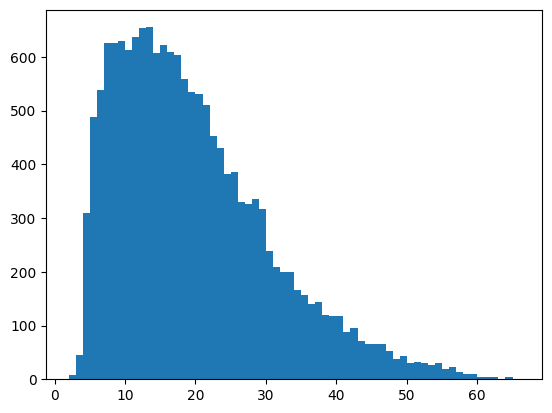

In [17]:
length = [len(t.split(' ')) for t in tweets]
plt.hist(length, bins = len(set(length)))
plt.show()

In [18]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding = 'post', maxlen=maxlen)
  return padded

In [20]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [21]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

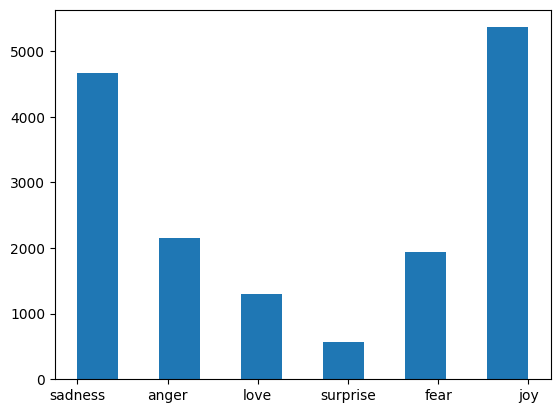

In [23]:
plt.hist(emotional_labels, bins =11)
plt.show()

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(12000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            192000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 207926 (812.21 KB)
Trainable params: 207926 (812.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
val_tweets, val_labels = get_tweet(valid)
val_seq = get_sequences(tokenizer, val_tweets)

In [27]:
 val_tweets[4], val_labels[4]

('i can have for a treat or if i am feeling festive', 'joy')

In [28]:
valid[4]

{'text': 'i can have for a treat or if i am feeling festive', 'label': 1}

In [37]:
# Assuming 'valid' is a list of dictionaries
val_label = [data['label'] for data in valid]

In [38]:
train_label = [data['label'] for data in train]

In [39]:
train_label_np = np.array(train_label)
val_label_np = np.array(val_label)


In [43]:
history = model.fit(
    padded_train_seq, train_label_np,
    validation_data = (val_seq, val_label_np),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 0.7147 - val_accuracy: 0.8795
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0086 - accuracy: 0.9963 - val_loss: 0.6586 - val_accuracy: 0.8805
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0134 - accuracy: 0.9948 - val_loss: 0.6373 - val_accuracy: 0.8815
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0103 - accuracy: 0.9953 - val_loss: 0.6451 - val_accuracy: 0.8810
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0085 - accuracy: 0.9961 - val_loss: 0.6687 - val_accuracy: 0.8785
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0067 - accuracy: 0.9967 - val_loss: 0.6788 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.0062 - accuracy: 0.9967 - val_loss: 0.7245 - val_accuracy: 0.875

In [63]:
test_tweets, test_labels = get_tweet(test)
test_label_np = np.array(test_labels)


In [49]:
test_seq = get_sequences(tokenizer, test_tweets)

In [52]:
model.evaluate(test_seq, test_label_np)

63/63 [==============================] - 1s 8ms/step - loss: 0.7990 - accuracy: 0.8775


[0.7989516854286194, 0.8774999976158142]

In [65]:
import random
i = random.randint(0, len(test_label_np) - 1)
print('Sentence:', test_tweets[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')
predicted_label = label_mapping[pred_class]

print('Predicted Emotion:' , predicted_label)

Sentence: i also baked enough cookies to take to my local bbw tomorrow night i feel so bad for the employees who have to work
Emotion: sadness
1/1 [==============================] - 0s 22ms/step
Predicted Emotion: sadness
